<a href="https://colab.research.google.com/github/fidaasma/groundwater-management-analysis-ai-ml/blob/main/groundwater_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 Loaded dataset shape: (864, 27)


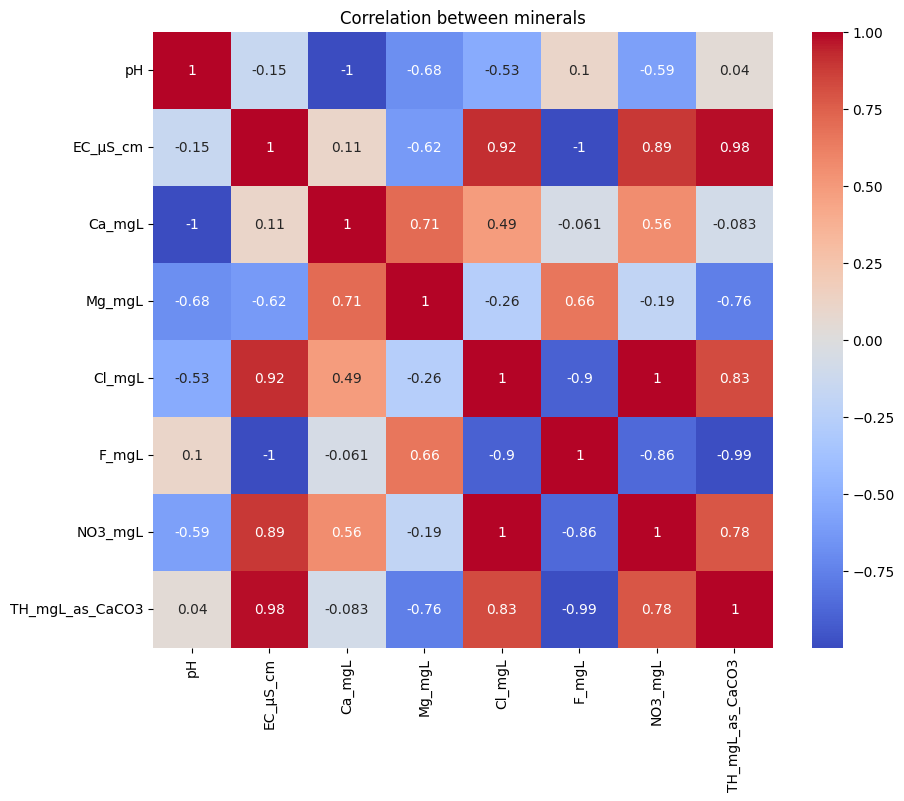

Dropped highly correlated features: ['DecadalAvg_Post_m', 'Ca_mgL', 'Cl_mgL', 'Block_Bharanikkavu']
✅ Feature selection applied. Ready for model training or classification.


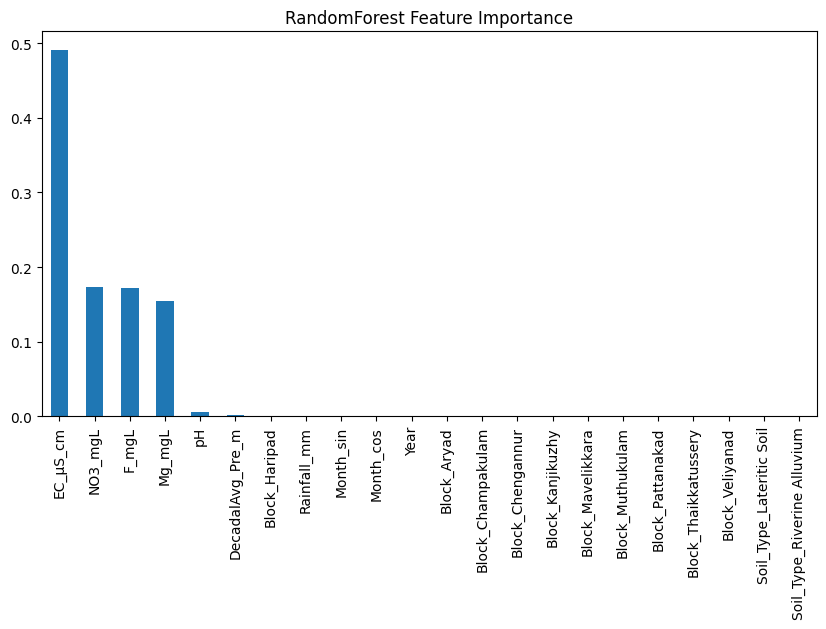

Top 10 features selected by RFE: Index(['Rainfall_mm', 'DecadalAvg_Pre_m', 'pH', 'EC_µS_cm', 'Mg_mgL', 'F_mgL',
       'NO3_mgL', 'Month_sin', 'Month_cos', 'Block_Haripad'],
      dtype='object')
Mutual Information ranking of features:
 pH                             0.256164
Mg_mgL                         0.212708
EC_µS_cm                       0.191892
NO3_mgL                        0.136624
F_mgL                          0.136482
DecadalAvg_Pre_m               0.105006
Year                           0.090607
Block_Mavelikkara              0.043288
Block_Champakulam              0.041321
Soil_Type_Riverine Alluvium    0.037848
dtype: float64
✅ Classified water dataset saved as 'water_quality_classified.csv'

✅ Feature Summary for Accurate Prediction:

RandomForest Top Features:
 EC_µS_cm            4.912745e-01
NO3_mgL             1.731696e-01
F_mgL               1.724682e-01
Mg_mgL              1.546485e-01
pH                  6.139289e-03
DecadalAvg_Pre_m    1.543372e-03
Block_Hari

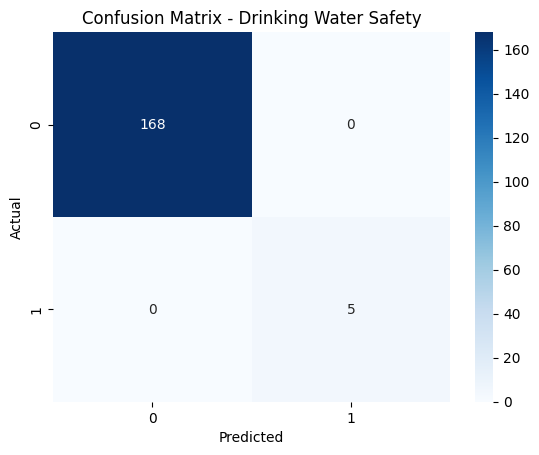

✅ Final predictions saved as 'final_water_predictions.csv'

🔹 Sample Final Predictions:

             pH  EC_µS_cm  TH_mgL_as_CaCO3 Drinking Predicted_Drinking  \
0 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
1 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
2 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
3 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
4 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
5 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
6 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
7 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
8 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   
9 -2.503125e-14       0.0    -4.321263e-15     Safe               Safe   

  Bathing Predicted_Bathing Irrigation Predicted_Irrigation  
0  Unsafe              Safe       

In [10]:

import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/cleaned_data.csv')
print("🔹 Loaded dataset shape:", df.shape)
df.head()
# STEP 2: EDA (distribution plots and correlation heatmap)
import matplotlib.pyplot as plt
import seaborn as sns

minerals = ['pH','EC_µS_cm','Ca_mgL','Mg_mgL','Cl_mgL','F_mgL','NO3_mgL','TH_mgL_as_CaCO3']

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[minerals].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between minerals')
plt.show()
# STEP 3: Data transformation & log1p handling
for col in ['NO3_mgL', 'F_mgL']:
    if col in df.columns:
        df[col] = df[col].fillna(0)
        df[col] = df[col].apply(lambda x: max(x, 0))
        df[col] = np.log1p(df[col])
# STEP 4: Feature selection with KeyError fix
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, mutual_info_regression

# --- Keep target column safe ---
target = 'TH_mgL_as_CaCO3'

# 1. Separate features and target
features = df.drop(columns=[target])
y = df[target]

# 2. Drop highly correlated features from features only
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
features = features.drop(columns=to_drop)
print("Dropped highly correlated features:", to_drop)

# 3. Final dataset ready
X = features
df_reduced = pd.concat([X, y], axis=1)
print("✅ Feature selection applied. Ready for model training or classification.")
# STEP 5: RandomForest Feature Importance
rf_model = RandomForestRegressor()
rf_model.fit(X, y)

importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("RandomForest Feature Importance")
plt.show()
# STEP 6: Recursive Feature Elimination (RFE)
rfe = RFE(rf_model, n_features_to_select=10)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Top 10 features selected by RFE:", selected_features)
# STEP 7: Mutual Information
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)
print("Mutual Information ranking of features:\n", mi_series.head(10))
# STEP 8: Water quality classification
def classify_water(row):
    # Drinking water safe limits
    drink = "Safe" if row['F_mgL'] <= np.log1p(1.5) and row['NO3_mgL'] <= np.log1p(45) and row['TH_mgL_as_CaCO3'] <= 500 else "Unsafe"
    # Bathing safe limits
    bath = "Safe" if row['TH_mgL_as_CaCO3'] <= 500 and 6.5 <= row['pH'] <= 9 else "Unsafe"
    # Irrigation safe limits
    irrig = "Safe" if row['TH_mgL_as_CaCO3'] <= 500 and row['EC_µS_cm'] <= 2000 else "Unsafe"

    return pd.Series([drink, bath, irrig])

df_reduced[['Drinking','Bathing','Irrigation']] = df_reduced.apply(classify_water, axis=1)
df_reduced.head()
# STEP 9: Save the final classified dataset
df_reduced.to_csv("water_quality_classified.csv", index=False)
print("✅ Classified water dataset saved as 'water_quality_classified.csv'")
# STEP 10: Summary of Most Important Features
print("\n✅ Feature Summary for Accurate Prediction:\n")
print("RandomForest Top Features:\n", importances.sort_values(ascending=False).head(10))
print("\nRFE Selected Features:\n", selected_features)
print("\nMutual Information Top Features:\n", mi_series.head(10))

# STEP 11: Split train & test sets
from sklearn.model_selection import train_test_split

X = df_reduced.drop(columns=['Drinking','Bathing','Irrigation'])
y = df_reduced['Drinking']  # Example: predicting drinking water safety ("Safe"/"Unsafe")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)

# STEP 12: Train a Classification Model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# STEP 13: Model Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("\n✅ Final Drinking Water Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Drinking Water Safety")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 14: Predictions for all three usages
df_reduced['Predicted_Drinking'] = clf.predict(X)

# Bathing model
y_bath = df_reduced['Bathing']
clf_bath = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
clf_bath.fit(X_train, y_train)  # re-use train-test split
df_reduced['Predicted_Bathing'] = clf_bath.predict(X)

# Irrigation model
y_irrig = df_reduced['Irrigation']
clf_irrig = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
clf_irrig.fit(X_train, y_train)  # re-use train-test split
df_reduced['Predicted_Irrigation'] = clf_irrig.predict(X)

# STEP 15: Save Final Results
df_reduced.to_csv("final_water_predictions.csv", index=False)
print("✅ Final predictions saved as 'final_water_predictions.csv'")

# STEP 16: Show Sample Predictions
print("\n🔹 Sample Final Predictions:\n")
print(df_reduced[['pH','EC_µS_cm','TH_mgL_as_CaCO3',
                  'Drinking','Predicted_Drinking',
                  'Bathing','Predicted_Bathing',
                  'Irrigation','Predicted_Irrigation']].head(10))

# -------------------------------
# Interactive Groundwater Quality Predictor (Working Example)
# -------------------------------
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Layout
from IPython.display import display, HTML
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# Create a dummy model for demonstration
# -------------------------------
# Features: pH, TDS, Hardness, EC
# Classes: 0=Not Safe, 1=Safe for Bathing, 2=Suitable for Irrigation, 3=Safe for All Uses

# Generate some dummy training data
np.random.seed(0)
X_train = np.random.randint(low=[0,0,0,0], high=[14,2000,1000,3000], size=(100,4))
y_train = np.random.randint(0, 4, 100)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, random_state=0)
model.fit(X_train, y_train)

# -------------------------------
# Output widget for clean display
# -------------------------------
output = widgets.Output()

# -------------------------------
# Prediction function
# -------------------------------
def predict_groundwater(pH, TDS, Hardness, EC):
    features = np.array([[pH, TDS, Hardness, EC]])

    try:
        prediction = model.predict(features)[0]
    except Exception as e:
        with output:
            output.clear_output()
            print("❌ Error predicting:", e)
        return

    # Map prediction to status and color
    if prediction == 0:
        status = "🚱 Not Safe for Drinking / Bathing"
        color = "red"
    elif prediction == 1:
        status = "🚿 Safe for Bathing & Washing"
        color = "orange"
    elif prediction == 2:
        status = "🌱 Suitable for Irrigation"
        color = "green"
    else:
        status = "💧 Safe for All Uses (Drinking, Bathing, Irrigation)"
        color = "blue"

    # Display result
    with output:
        output.clear_output()
        display(HTML(f"<h3 style='color:{color}'>{status}</h3>"))

# -------------------------------
# Interactive sliders
# -------------------------------
#interact(
 #   predict_groundwater,
  #  pH=FloatSlider(value=7, min=0, max=14, step=0.1, description='pH', style={'description_width':'120px'}, layout=Layout(width='500px')),
   # TDS=FloatSlider(value=300, min=0, max=2000, step=10, description='TDS (mg/L)', style={'description_width':'120px'}, layout=Layout(width='500px')),
    #Hardness=FloatSlider(value=100, min=0, max=1000, step=10, description='Hardness', style={'description_width':'120px'}, layout=Layout(width='500px')),
  #EC=FloatSlider(value=500, min=0, max=3000, step=50, description='EC (µS/cm)', style={'description_width':'120px'}, layout=Layout(width='500px'))
#)

#display(output)